#  Optimal Restaurant Location Finder Toronto 


In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors

## First we will be using BeautifulSoup to scrape wikipedia for neighbourhood information, including Postal Code Borough, and Neighborhood. The information is to be stored in dataframe df_Toronto.

In [2]:
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
# page.content;
soup= BeautifulSoup(page.content,"xml")
# print(soup.prettify());
table= soup.find('table',{'class':'wikitable sortable'})
table_rows=table.findAll('tr')
data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])
df_Toronto= pd.DataFrame(data, columns=['Postal Code','Borough','Neighbourhood'])
df_Toronto=df_Toronto[~df_Toronto['Postal Code'].isnull()]



## Clean data by removeing "Not assigned", any "Not assigned" in Neighbourhood will be replaced with Borough value

In [3]:
df_Toronto.head()

,Postal Code,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
df_Toronto= df_Toronto[df_Toronto.Borough!="Not assigned"]


In [5]:
df_Toronto

,Postal Code,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
161,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
166,M4Y,Downtown Toronto,Church and Wellesley
169,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
170,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [6]:
df_Toronto.Neighbourhood.replace("Not assigned",df_Toronto.Borough,inplace=True)
df_Toronto.shape

(103, 3)

## Obtain Latitude and Longitude from csv and merge to original Tlocation_df


In [7]:
df_lat_long= pd.read_csv(r'C:\Users\BK\Desktop\projects\Coursera_Capstone\KMeans\Geospatial_Coordinates.csv')
df_lat_long.isna().sum()
df_lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
Tlocation_df= df_Toronto.merge(df_lat_long,on= "Postal Code", how = "left")
Tlocation_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [9]:
Tlocation_df.isna().sum()

Postal Code      0
Borough          0
Neighbourhood    0
Latitude         0
Longitude        0
dtype: int64

In [10]:
import folium
from sklearn.cluster import KMeans

## Use geolocator to convert latitude and longitude, and use Folium visualize the neighbourhood on the map

In [11]:


!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ON_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))



Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\BK\anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.4                |   py37hc8dfbb8_2         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following packages will be UPDATED:

  conda                                4.8.3-py37hc8dfbb8_1 --> 4.8.4-py37hc8dfbb8_2




conda-4.8.4          | 3.1 MB    |            |   0% 
conda-4.8.4          | 3.1 MB    |            |   1% 
conda-4.8.4          | 3.1 MB    | 3          |   4% 
conda-4.8.4          | 3.1 MB    | 6          |   7% 
conda-4.8.4          | 3.1 MB    | 8          |   8% 
conda-4.8.4          | 3.1 MB    | #          |  11% 
conda-4.8.4          | 3.1 MB    | #4         

In [12]:

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
Limit=100
for lat, lng, borough, neighborhood in zip(Tlocation_df['Latitude'], Tlocation_df['Longitude'], Tlocation_df['Borough'], Tlocation_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


## In this section we will be getting nearby venues for each neighborhood along with the type of venue using the FourSquare API

In [13]:
import json

with open('Secretkey.json') as f:
    data = json.load(f)
    CLIENT_SECRET = data['Secretkey']

In [14]:
CLIENT_ID = 'LAH4R3HEEGAT000NXVQVWZQOQN111D0FEABC1GJRJIFWS5AK' 
VERSION = '20180605' # Foursquare API version

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            Limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:

Toronto_venues = getNearbyVenues(names=Tlocation_df['Neighbourhood'],
                                   latitudes=Tlocation_df['Latitude'],
                                   longitudes=Tlocation_df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

##  Create dummy variable for each venue and get the mean frequency per venue, then merge to to get associated neighborhoods.


In [19]:


# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()



,Zoo Exhibit,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped



,Neighborhood,Zoo Exhibit,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,Agincourt,0.0,0.00,0.0,0.00,0.0,0.01,0.0,0.0,0.0,...,0.01,0.00,0.02,0.00,0.0,0.000000,0.00,0.010000,0.00,0.0
1,"Alderwood, Long Branch",0.0,0.00,0.0,0.00,0.0,0.01,0.0,0.0,0.0,...,0.00,0.01,0.01,0.01,0.0,0.000000,0.00,0.000000,0.02,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.00,0.0,0.01,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.01,0.0,0.000000,0.01,0.000000,0.00,0.0
3,Bayview Village,0.0,0.00,0.0,0.00,0.0,0.01,0.0,0.0,0.0,...,0.01,0.00,0.01,0.00,0.0,0.000000,0.00,0.000000,0.00,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.00,0.0,0.01,0.0,0.02,0.0,0.0,0.0,...,0.00,0.00,0.00,0.01,0.0,0.000000,0.00,0.000000,0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Willowdale, Willowdale West",0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.01,0.00,0.01,0.00,0.0,0.010000,0.00,0.000000,0.00,0.0
95,Woburn,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.010526,0.00,0.010526,0.00,0.0
96,Woodbine Heights,0.0,0.01,0.0,0.00,0.0,0.02,0.0,0.0,0.0,...,0.01,0.00,0.00,0.01,0.0,0.000000,0.00,0.000000,0.00,0.0
97,York Mills West,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.010000,0.00,0.000000,0.00,0.0


## Filter the venues to only restaurants

In [21]:
Restaurant=Toronto_grouped.filter(like='Restaurant').columns
Toronto_Data=Toronto_grouped.loc[:,(Restaurant)]
Toronto_Data=Toronto_Data.set_index(Toronto_grouped['Neighborhood'])
Toronto_Data
Toronto_Data.reset_index(inplace=True)
Toronto_Data.head()


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,...,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,Agincourt,0.0,0.0,0.01,0.01,0.0,0.02,0.05,0.0,0.06,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.02,0.01
1,"Alderwood, Long Branch",0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.01,0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.00,0.01,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00
3,Bayview Village,0.0,0.0,0.01,0.00,0.0,0.00,0.01,0.0,0.03,...,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.01,0.01,0.00
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.02,0.00,0.0,0.00,0.01,0.0,0.01,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00


## Allow User to input what type of restaurant they want to open

In [22]:
Type= input() + " Restaurant"

# Type= "Sushi Restaurant"


Sushi


## Review Data:Mean Frequencies, and top 5 Neighbourhoods

In [23]:
Restaurants=Toronto_Data.loc[:,Type]
Restaurants.max()

0.05

In [24]:
new= Toronto_Data[["Neighborhood",Type]]
new.sort_values(by=Type, ascending=False).head()


,Neighborhood,Sushi Restaurant
59,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.05
97,York Mills West,0.05
54,"New Toronto, Mimico South, Humber Bay Shores",0.04
47,Lawrence Park,0.04
16,"Clarks Corners, Tam O'Shanter, Sullivan",0.03


## Apply Unsupervised Machine Learning Clustering Algorithm, KMeans. Find Optimal K using Elbow Point.

In [25]:
Toronto_Data_K=Toronto_Data.drop('Neighborhood', 1)
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(Toronto_Data_K)
    distortions.append(kmeanModel.inertia_)

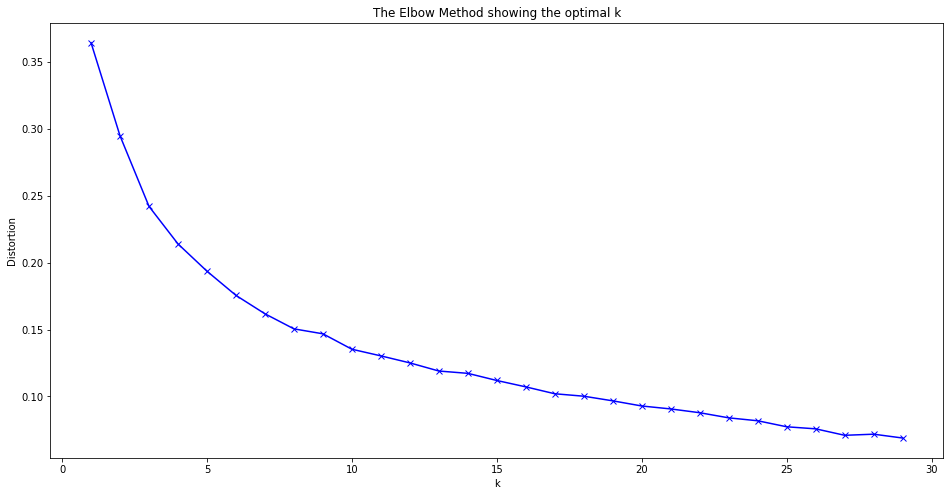

In [26]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [27]:
# set number of clusters
kclusters = 6


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_Data_K)

## Reviewing Data Again

In [28]:
Toronto_Data_K.insert(0, 'Cluster Labels', kmeans.labels_)
Toronto_Data_K.insert(0, 'Neighborhood', Toronto_Data.Neighborhood)

Toronto_Data_K.head()


,Neighborhood,Cluster Labels,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,...,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,Agincourt,5,0.0,0.0,0.01,0.01,0.0,0.02,0.05,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.02,0.01
1,"Alderwood, Long Branch",1,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.01,0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",1,0.0,0.0,0.00,0.01,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00
3,Bayview Village,4,0.0,0.0,0.01,0.00,0.0,0.00,0.01,0.0,...,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.01,0.01,0.00
4,"Bedford Park, Lawrence Manor East",2,0.0,0.0,0.02,0.00,0.0,0.00,0.01,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00


In [29]:
Toronto_Data.head()
Toronto_Data.isna().sum()

Neighborhood                     0
Afghan Restaurant                0
African Restaurant               0
American Restaurant              0
Asian Restaurant                 0
Brazilian Restaurant             0
Cantonese Restaurant             0
Caribbean Restaurant             0
Caucasian Restaurant             0
Chinese Restaurant               0
Cuban Restaurant                 0
Doner Restaurant                 0
Dumpling Restaurant              0
Eastern European Restaurant      0
Egyptian Restaurant              0
Ethiopian Restaurant             0
Falafel Restaurant               0
Fast Food Restaurant             0
Filipino Restaurant              0
French Restaurant                0
Greek Restaurant                 0
Hakka Restaurant                 0
Hotpot Restaurant                0
Hungarian Restaurant             0
Indian Chinese Restaurant        0
Indian Restaurant                0
Indonesian Restaurant            0
Italian Restaurant               0
Japanese Restaurant 

In [30]:

Toronto_Data_K.reset_index(inplace=True)
Toronto_merged=Tlocation_df
Toronto_merged = Toronto_merged.join(Toronto_Data_K.set_index('Neighborhood'), on='Neighbourhood')


In [31]:
Toronto_merged.isna().sum()
Toronto_merged.head(20)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,index,Cluster Labels,Afghan Restaurant,African Restaurant,American Restaurant,...,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,M3A,North York,Parkwoods,43.753259,-79.329656,62,3,0.00,0.01,0.02,...,0.0,0.0,0.00,0.010000,0.00,0.0,0.010,0.000,0.01,0.00
1,M4A,North York,Victoria Village,43.725882,-79.315572,87,3,0.01,0.00,0.02,...,0.0,0.0,0.00,0.000000,0.00,0.0,0.010,0.000,0.01,0.00
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,64,1,0.00,0.00,0.01,...,0.0,0.0,0.00,0.010000,0.01,0.0,0.000,0.010,0.00,0.00
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,46,2,0.00,0.00,0.02,...,0.0,0.0,0.00,0.010000,0.00,0.0,0.000,0.000,0.03,0.00
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,63,1,0.00,0.00,0.01,...,0.0,0.0,0.00,0.010000,0.01,0.0,0.000,0.020,0.01,0.00
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,42,1,0.00,0.00,0.00,...,0.0,0.0,0.01,0.010000,0.00,0.0,0.000,0.000,0.00,0.00
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,50,0,0.00,0.00,0.00,...,0.0,0.0,0.00,0.000000,0.00,0.0,0.000,0.000,0.00,0.00
7,M3B,North York,Don Mills,43.745906,-79.352188,22,3,0.01,0.00,0.01,...,0.0,0.0,0.00,0.005000,0.00,0.0,0.005,0.005,0.01,0.00
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,61,1,0.01,0.00,0.02,...,0.0,0.0,0.00,0.010000,0.00,0.0,0.010,0.010,0.01,0.00
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,31,1,0.00,0.00,0.01,...,0.0,0.0,0.00,0.010000,0.01,0.0,0.000,0.020,0.01,0.00


## Visualize Map Clusters

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_Data_K['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Finding which cluster has the highest Mean Frequency & choosing optimal cluster accordingly

In [33]:

clusters= Toronto_Data_K[['Neighborhood','Cluster Labels',Type]]
clusters = clusters.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusters.head()


Cluster Labels,0,1,2,3,4,5
Sushi Restaurant,0.095218,0.4,0.23,0.09,0.12,0.07


In [34]:
Cluster0=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0,Toronto_merged.columns[[2,3,4] + list(range(6, Toronto_merged.shape[1]))]]
Cluster0.reset_index(inplace = True) 
Cluster0.drop(columns=['index'],inplace=True)

Cluster0

,Neighbourhood,Latitude,Longitude,Cluster Labels,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,...,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,"Malvern, Rouge",43.806686,-79.194353,0,0.00,0.00,0.00,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.000000
1,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,0.00,0.00,0.01,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.000000,0.010000
2,Woburn,43.770992,-79.216917,0,0.00,0.00,0.00,0.000000,0.0,0.010526,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.010526
3,Cedarbrae,43.773136,-79.239476,0,0.00,0.00,0.01,0.020000,0.0,0.020000,...,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.000000,0.010000
4,Scarborough Village,43.744734,-79.239476,0,0.00,0.01,0.01,0.010000,0.0,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.010000,0.010000
5,Humber Summit,43.756303,-79.565963,0,0.00,0.00,0.01,0.020000,0.0,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.010000,0.000000
6,"Humberlea, Emery",43.724766,-79.532242,0,0.00,0.00,0.02,0.030000,0.0,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.040000,0.000000
7,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,0,0.00,0.00,0.00,0.037037,0.0,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.012346,0.000000
8,"Northwest, West Humber - Clairville",43.706748,-79.594054,0,0.01,0.00,0.02,0.020000,0.0,0.000000,...,0.0,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.000000,0.000000
9,Upper Rouge,43.836125,-79.205636,0,0.01,0.00,0.00,0.010000,0.0,0.010000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.000000


In [35]:
Neigh_list = Cluster0['Neighbourhood'].tolist()


## Get nearby venues for neighbourhoods in cluster 0

In [36]:
def getNearbyVenues2(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            Limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:

Cluster_venues_= getNearbyVenues2(names=Cluster0.Neighbourhood,
                                   latitudes=Cluster0.Latitude,
                                   longitudes=Cluster0.Longitude
                                  )


Malvern, Rouge
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Humber Summit
Humberlea, Emery
South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens
Northwest, West Humber - Clairville
Upper Rouge


## Counting  all of the different restaurants that are visited in each neighborhood. Using this to compare the demand(Frequency in Neighbourhood) with supply(Different Restaurants in Neighbourhood)

In [38]:
Venues=Cluster_venues_.loc[Cluster_venues_['Venue Category'] == "Sushi Restaurant"]
Venues.head()

Cluster_venues_type=Venues
Cluster_venues_type=Cluster_venues_type.Neighborhood.value_counts()
Cluster_venues_type=Cluster_venues_type.to_frame()
Cluster_venues_type.reset_index( inplace=True)


In [39]:
Cluster_venues_type.columns=["Neighbourhood", "visits per Neighbourhood"]
Cluster_venues_type

,Neighbourhood,visits per Neighbourhood
0,Scarborough Village,2
1,"South Steeles, Silverstone, Humbergate, Jamest...",2
2,Humber Summit,2
3,Woburn,1
4,"Northwest, West Humber - Clairville",1
5,Cedarbrae,1


In [41]:
Freq=Cluster0.loc[:,("Neighbourhood",Type)]
Freq=Freq[Freq[Type]>0]
Freq



,Neighbourhood,Sushi Restaurant
2,Woburn,0.010526
3,Cedarbrae,0.010000
4,Scarborough Village,0.020000
5,Humber Summit,0.020000
7,"South Steeles, Silverstone, Humbergate, Jamest...",0.024691
8,"Northwest, West Humber - Clairville",0.010000


In [42]:
Cluster_venues_type=Cluster_venues_type.merge(Freq, on='Neighbourhood')
Cluster_venues_type.drop_duplicates(subset ="Neighbourhood", keep = 'first', inplace = True) 


## Sorting Based on unique visits per neighbourhood and frequency of Sushi Restaurant

In [43]:
Cluster_venues_type.sort_values(["visits per Neighbourhood",Type], ascending=[True,False],inplace=True)
Cluster_venues_type.reset_index(inplace=True)
del Cluster_venues_type['index']
Cluster_venues_type

,Neighbourhood,visits per Neighbourhood,Sushi Restaurant
0,Woburn,1,0.010526
1,"Northwest, West Humber - Clairville",1,0.010000
2,Cedarbrae,1,0.010000
3,"South Steeles, Silverstone, Humbergate, Jamest...",2,0.024691
4,Scarborough Village,2,0.020000
5,Humber Summit,2,0.020000


## Visualize Optimal Location Using Bar Chart,  using Indexes instead of neighbourhood name

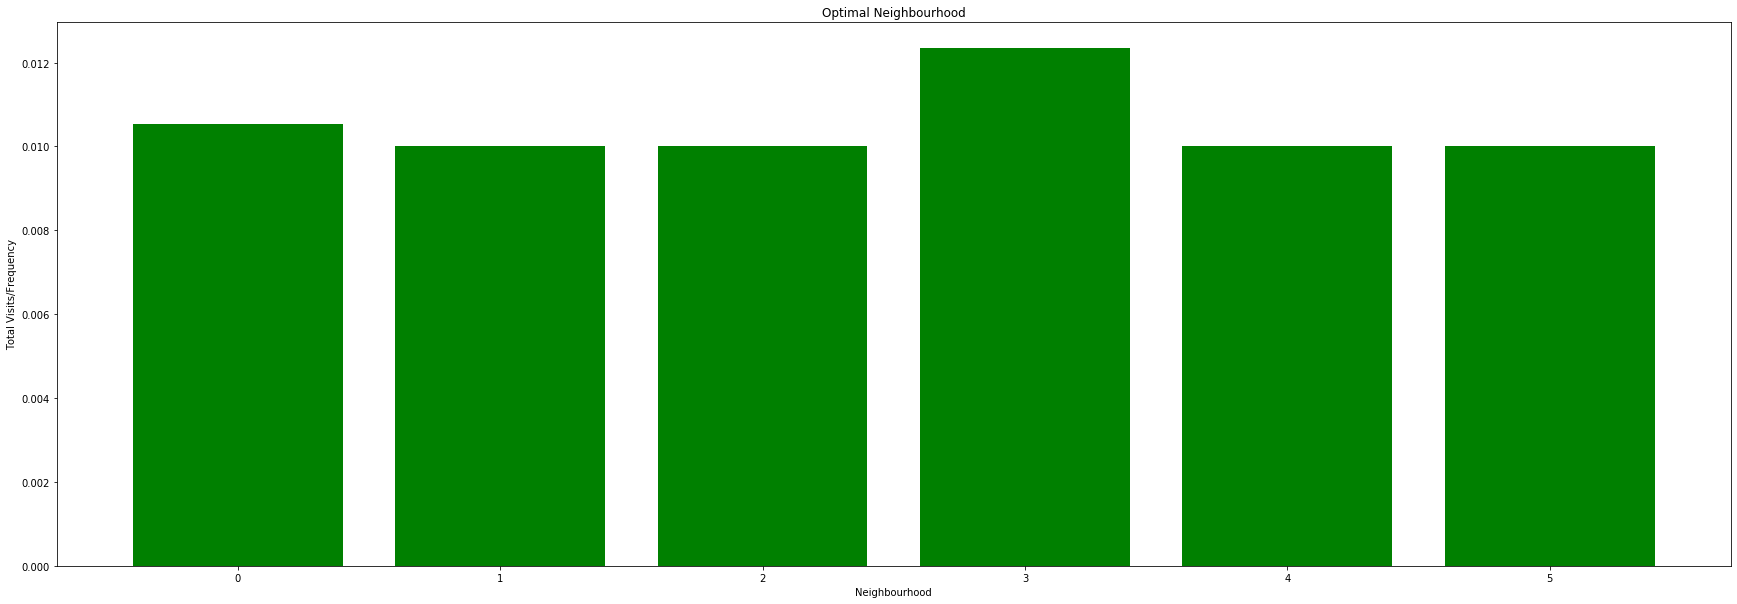

In [44]:
fig = plt.figure(figsize=(30,10))
x=Cluster_venues_type.index
temp="visits per Neighbourhood"
y=Cluster_venues_type[Type]/Cluster_venues_type[temp]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("Neighbourhood")
plt.ylabel("Total Visits/Frequency")
plt.title("Optimal Neighbourhood")

plt.xticks(x_pos, x)
plt.show()